In [57]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import warnings 
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
p = matplotlib.rcParams
p["font.size"] = 25
p["axes.unicode_minus"] = False
p['lines.linewidth'] = 3
p['pdf.fonttype'] = 42
p['ps.fonttype'] = 42
p["figure.figsize"] = [12, 12]
p['grid.color'] = 'k'
p['grid.linestyle'] = ':'
p['grid.linewidth'] = 0.5
cmap = plt.get_cmap('viridis')
#colors = cmap(np.linspace(0, 1, n)) #n: number of the lines you want to plot 
import seaborn as sns
sns.set(style="whitegrid")

In [58]:
features = pd.read_csv('spx_cons_norm.csv')
features = features[['tic','datadate','industry_id','forward_excess_ret','ROE','Asset Turnover','EMA6','earningsVol','PS','ev_ebitda']]
industry_dummy = pd.get_dummies(features['industry_id'])
features = pd.merge(features,industry_dummy,how='left',left_index=True,right_index=True)

features = features.dropna(subset=['forward_excess_ret'])
features_after = features.groupby(['tic']).ffill()
features_after = pd.merge(features_after,features[['tic']],how='left',left_index=True,right_index=True)

cols = [col for col in features_after.columns if col not in ['datadate','industry_id','forward_excess_ret','tic']]
df_na = features_after.isnull()

df_mean = features_after.groupby('tic').mean()

In [59]:
for col in cols:
    na_series = features_after[col].isnull()
    names = list(features_after.loc[na_series,'tic'])     

    t = df_mean.loc[names,col]
    t.index = features_after.loc[na_series,col].index

    
    features_after.loc[na_series,col] = t



for col in cols:
    na_series = features_after[col].isnull()
    mean = np.mean(features_after[col]) 
    features_after.loc[na_series,col] = mean

In [60]:
feature_names=['ROE','Asset Turnover','EMA6','earningsVol','PS','ev_ebitda',10,15,20,25,30,35,40,45,50,55,60]
X = features_after[feature_names]
#X = sm.add_constant(X)
Y = features_after[['forward_excess_ret']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=52)

## Prediction

### Linear

In [61]:
#Linear
reg = LassoCV(cv=5,fit_intercept=True,alphas=np.linspace(0.00001,0.001,100)).fit(X_train,y_train)   
print(reg.alphas_)
print(reg.coef_)
print(reg.intercept_)

[1.0e-03 9.9e-04 9.8e-04 9.7e-04 9.6e-04 9.5e-04 9.4e-04 9.3e-04 9.2e-04
 9.1e-04 9.0e-04 8.9e-04 8.8e-04 8.7e-04 8.6e-04 8.5e-04 8.4e-04 8.3e-04
 8.2e-04 8.1e-04 8.0e-04 7.9e-04 7.8e-04 7.7e-04 7.6e-04 7.5e-04 7.4e-04
 7.3e-04 7.2e-04 7.1e-04 7.0e-04 6.9e-04 6.8e-04 6.7e-04 6.6e-04 6.5e-04
 6.4e-04 6.3e-04 6.2e-04 6.1e-04 6.0e-04 5.9e-04 5.8e-04 5.7e-04 5.6e-04
 5.5e-04 5.4e-04 5.3e-04 5.2e-04 5.1e-04 5.0e-04 4.9e-04 4.8e-04 4.7e-04
 4.6e-04 4.5e-04 4.4e-04 4.3e-04 4.2e-04 4.1e-04 4.0e-04 3.9e-04 3.8e-04
 3.7e-04 3.6e-04 3.5e-04 3.4e-04 3.3e-04 3.2e-04 3.1e-04 3.0e-04 2.9e-04
 2.8e-04 2.7e-04 2.6e-04 2.5e-04 2.4e-04 2.3e-04 2.2e-04 2.1e-04 2.0e-04
 1.9e-04 1.8e-04 1.7e-04 1.6e-04 1.5e-04 1.4e-04 1.3e-04 1.2e-04 1.1e-04
 1.0e-04 9.0e-05 8.0e-05 7.0e-05 6.0e-05 5.0e-05 4.0e-05 3.0e-05 2.0e-05
 1.0e-05]
[ 0.00000000e+00  3.31467003e-04 -3.02456003e-04 -0.00000000e+00
 -2.22762116e-05  4.42982067e-04 -4.12440044e-03 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.32483

### KNN

In [62]:
#KNN

for n in [2,3,4,5,6,7,8]:
    neigh = KNeighborsRegressor(n_neighbors=n)
    #neigh.fit(X_train,y_train)
    scores = cross_val_score(neigh, X_train,y_train, cv=5)
    print(n,np.mean(scores))

2 -0.46411379282118287
3 -0.3075805333184049
4 -0.23244345401279856
5 -0.18404651107889558
6 -0.15601523748745355
7 -0.13263829380784106
8 -0.11612589824463396


### Random Forest

In [63]:
#random forest

for max_depth in [2,3,4,5,6,7]:
    regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
    scores = cross_val_score(regr, X_train,y_train, cv=5)
    print(max_depth,np.mean(scores))

2 -5.244963310520045e-05
3 3.706107298195871e-05
4 6.266109790511453e-05
5 -0.0002929393545936687
6 -0.00032736725501354426
7 -0.0010444483953069516


### SVR

In [74]:
#SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline


SVR_m = SVR()
param_grid0 = {'C': [0.01, 0.1], 'epsilon':[0.2,0.3]}
grid_search0 = GridSearchCV(SVR_m, scoring = 'neg_mean_squared_error',param_grid = param_grid0, cv=5, return_train_score=True)

grid_search0.fit(X_train, y_train) 

print("Scores on training set:")
means = grid_search0.cv_results_['mean_test_score']
stds = grid_search0.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search0.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Scores on training set:
-0.005 (+/-0.000) for {'C': 0.01, 'epsilon': 0.2}
-0.005 (+/-0.000) for {'C': 0.01, 'epsilon': 0.3}
-0.005 (+/-0.000) for {'C': 0.1, 'epsilon': 0.2}
-0.006 (+/-0.000) for {'C': 0.1, 'epsilon': 0.3}


In [75]:
print(grid_search0.cv_results_) 
print(grid_search0.best_params_)

{'mean_fit_time': array([0.73301539, 0.18098927, 0.99338036, 0.18558259]), 'std_fit_time': array([0.06065927, 0.02017872, 0.08343319, 0.01479536]), 'mean_score_time': array([0.11661177, 0.03159351, 0.14641242, 0.02861719]), 'std_score_time': array([0.0102217 , 0.00135478, 0.0317689 , 0.00185819]), 'param_C': masked_array(data=[0.01, 0.01, 0.1, 0.1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_epsilon': masked_array(data=[0.2, 0.3, 0.2, 0.3],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.01, 'epsilon': 0.2}, {'C': 0.01, 'epsilon': 0.3}, {'C': 0.1, 'epsilon': 0.2}, {'C': 0.1, 'epsilon': 0.3}], 'split0_test_score': array([-0.00470842, -0.00524571, -0.0050708 , -0.00582488]), 'split1_test_score': array([-0.00436114, -0.0048922 , -0.0046925 , -0.00565668]), 'split2_test_score': array([-0.00470296, -0.0054561 , -0.00509059, -0.00611526]), 'split3_test_score': ar

In [76]:
SVR_f = grid_search0.best_estimator_.fit(X_train, y_train)

y_hat0 = SVR_f.predict(X_test)
svm_score = SVR_f.score(X_test, y_test)
svm_score

-0.02134275265783958

### Decision Tree

In [64]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)

param_grid2 = {"criterion" : ["mse"],
              "max_depth" :   [2,3,4],
               'min_samples_split' : [2,5,10]
             }

grid_search3 = GridSearchCV(tree, param_grid=param_grid2,scoring='neg_mean_squared_error', cv=5, return_train_score = True)
grid_search3.fit(X_train, y_train) 

print("Scores on training set:")
means = grid_search3.cv_results_['mean_test_score']
stds = grid_search3.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search3.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print(grid_search3.best_params_)

Scores on training set:
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 5}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 10}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 2}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 5}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 10}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 2}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 5}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 10}
{'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 10}


In [65]:
print(grid_search3.cv_results_) 
print(grid_search3.best_params_)

{'mean_fit_time': array([0.12180471, 0.13062019, 0.13056512, 0.17742014, 0.1723568 ,
       0.17879739, 0.22241645, 0.22750368, 0.2352387 ]), 'std_fit_time': array([0.00095364, 0.00755423, 0.01427956, 0.01047668, 0.00232536,
       0.00287071, 0.0026593 , 0.00839047, 0.00716206]), 'mean_score_time': array([0.00743084, 0.00870519, 0.0070024 , 0.00776024, 0.007408  ,
       0.00768747, 0.00782127, 0.00869179, 0.00731549]), 'std_score_time': array([0.00048058, 0.00132643, 0.0006542 , 0.00117247, 0.00048499,
       0.00077157, 0.00041644, 0.00166166, 0.00079763]), 'param_criterion': masked_array(data=['mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse',
                   'mse'],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
             mask=[False, False, False, False, False, False, False, False,
                   

In [66]:
DT = grid_search3.best_estimator_.fit(X_train, y_train)

y_hat1 = DT.predict(X_test)
DT_score = DT.score(X_test, y_test)
DT_score

-0.006309954768688897

### Investigating the predictions

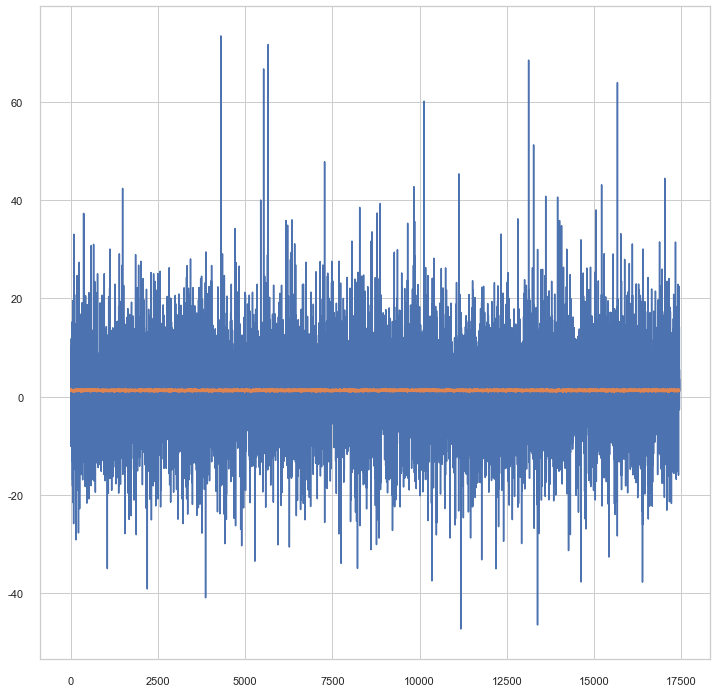

In [20]:
plt.plot(y_test.values.ravel())
plt.plot(y_hat0)

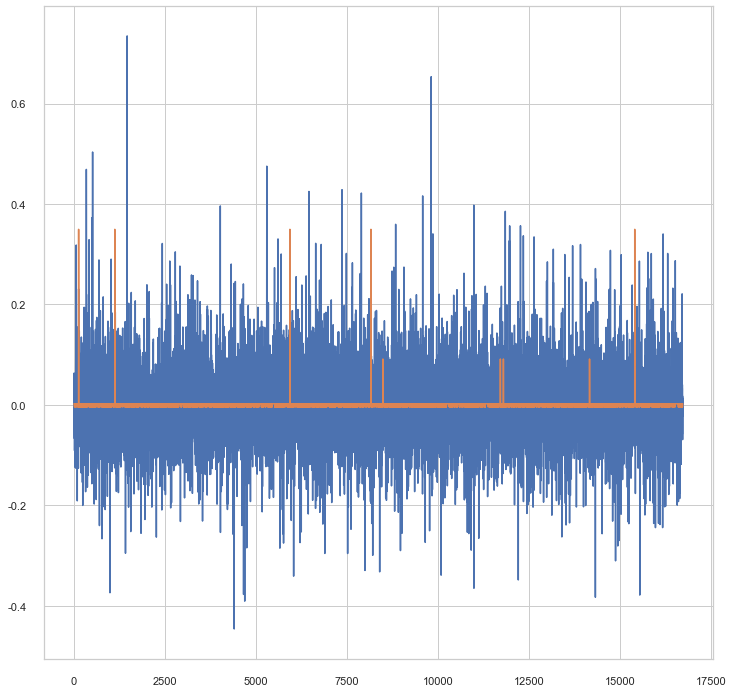

In [67]:
plt.plot(y_test.values.ravel())
plt.plot(y_hat1)

## Intertability

### Partial Dependance Plot

In [68]:
regr.fit(X_train,y_train)
print(sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), feature_names[:6]), reverse=True))

[(0.2143, 'EMA6'), (0.2024, 'ROE'), (0.157, 'ev_ebitda'), (0.1309, 'Asset Turnover'), (0.1057, 'PS'), (0.1026, 'earningsVol')]


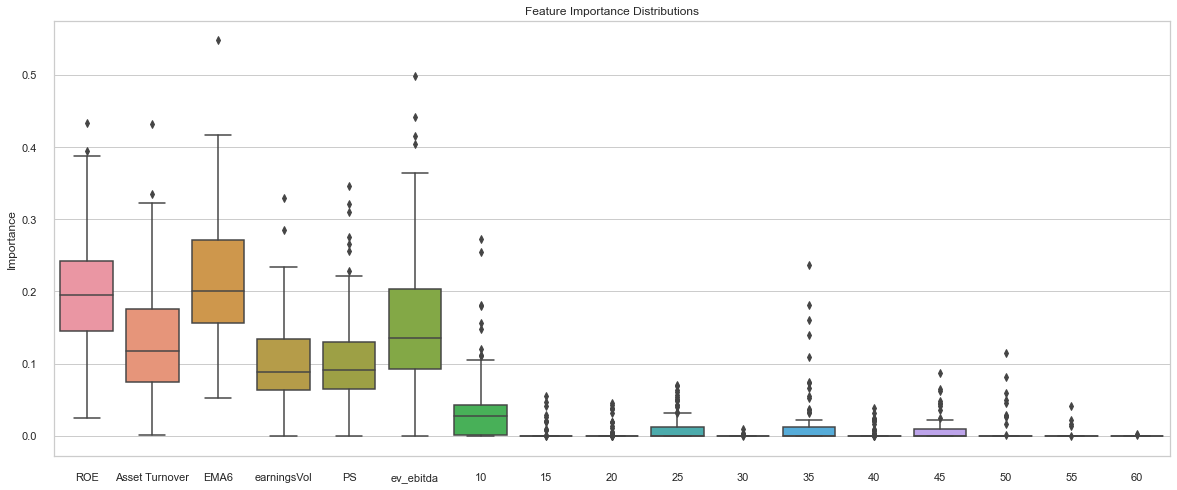

In [69]:
import seaborn as sns
p["figure.figsize"] = [20, 8]
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     regr],
                               columns=feature_names)

(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

### Feature Importance

#### Mean Decrease Impurity

In [70]:
import eli5
from eli5.sklearn import PermutationImportance
feat_imp_df = eli5.explain_weights_df(reg, feature_names=feature_names)
feat_imp_df

,target,feature,weight
0,y,45,0.002327
1,y,<BIAS>,0.001575
2,y,35,0.001325
3,y,ev_ebitda,0.000443
4,y,Asset Turnover,0.000331
5,y,PS,-0.000022
6,y,EMA6,-0.000302
7,y,10,-0.004124


#### Permutation Importance

In [71]:
perm = PermutationImportance(reg, random_state=1).fit(X_test, y_test)
#feature_names = feature_names.astype(str)
for i in range(0, len(feature_names)): 
    feature_names[i] = str(feature_names[i]) 
      
eli5.show_weights(perm, feature_names = feature_names)

Weight,Feature
0.0008 ± 0.0005,10
0.0002 ± 0.0005,45
0.0002 ± 0.0002,ev_ebitda
0.0002 ± 0.0001,Asset Turnover
0.0001 ± 0.0002,35
0.0000 ± 0.0001,EMA6
0 ± 0.0000,60
0 ± 0.0000,15
0 ± 0.0000,earningsVol
0 ± 0.0000,20


[(0.2143, 'EMA6'), (0.2024, 'ROE'), (0.157, 'ev_ebitda'), (0.1309, 'Asset Turnover'), (0.1057, 'PS'), (0.1026, 'earningsVol')]


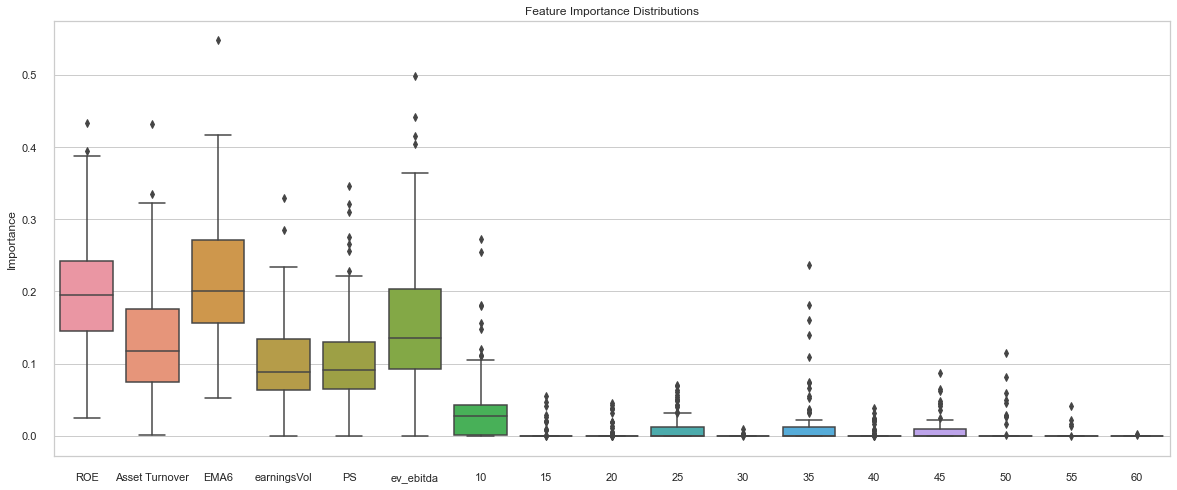

In [72]:
regr.fit(X_train,y_train)
print(sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), feature_names[:6]), reverse=True))
import seaborn as sns
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     regr],
                               columns=feature_names)

(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

#### ICE

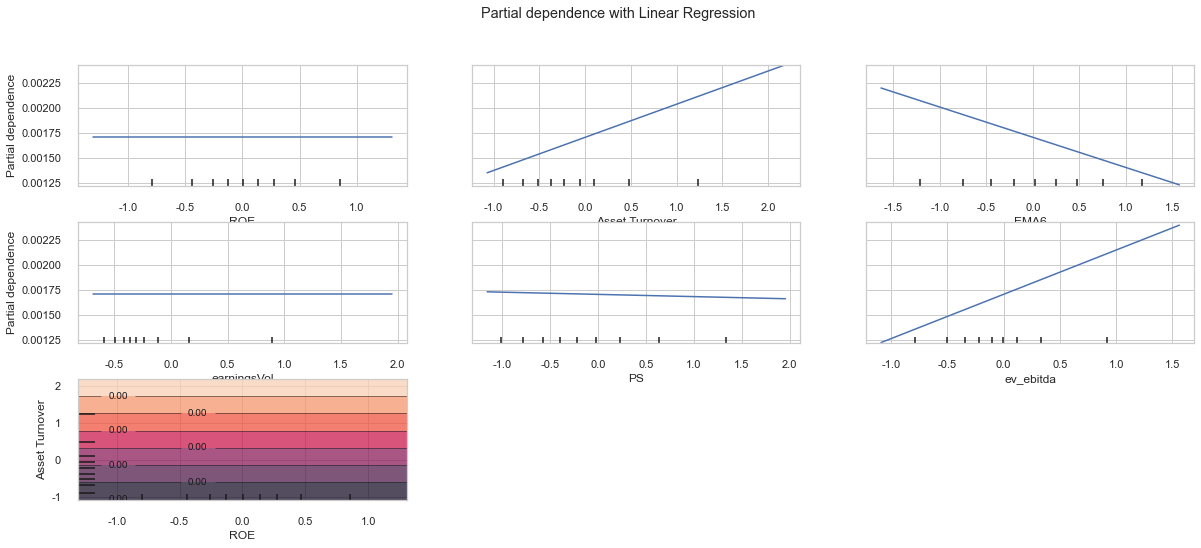

In [73]:
from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import plot_partial_dependence
from matplotlib import pyplot as plt
feature_names=['ROE','Asset Turnover','EMA6','earningsVol','PS','ev_ebitda',10,15,20,25,30,35,40,45,50,55,60]

features = list(range(6))
features.append((0,1))

plot_partial_dependence(reg, X_train, features, feature_names=feature_names[:6]) 
fig = plt.gcf()
fig.suptitle('Partial dependence with Linear Regression')
fig.subplots_adjust(hspace=0.3)